# Analyzing the output of the STEM simulation that used the multislice algorithm #

## A NOTE BEFORE STARTING ##

Since the ``prismatique`` git repository tracks this notebook under its original
basename ``analyzing_multislice_stem_sim_output.ipynb``, we recommend that you
copy the original notebook and rename it to any other basename that is not one
of the original basenames that appear in the ``<root>/examples`` directory
before executing any of the notebook cells below, where ``<root>`` is the root
of the ``prismatique`` repository. This way you can explore the notebook by
executing and modifying cells without changing the original notebook, which is
being tracked by git.

## Table of contents ##

- [Import necessary modules](#Import-necessary-modules)
- [Introduction](#Introduction)
- [Set paths to files storing output](#Set-paths-to-files-storing-output)
- [Load STEM simulation parameter set and represent it as Python object](#Load-STEM-simulation-parameter-set-and-represent-it-as-Python-object)
- [Extracting experiment properties](#Extracting-experiment-properties)
  - [Extract the probe scan pattern type](#Extract-the-probe-scan-pattern-type)
  - [Extract the underlying grid dimensions of the probe scan pattern](#Extract-the-underlying-grid-dimensions-of-the-probe-scan-pattern)
  - [Extract the probe positions](#Extract-the-probe-positions)
  - [Extract the output layer depths](#Extract-the-output-layer-depths)
  - [Extract the number of frozen phonon configurations in each subset](#Extract-the-number-of-frozen-phonon-configurations-in-each-subset)
  - [Extract the beam defocii](#Extract-the-beam-defocii)
  - [Extract $k_x$-coordinates of CBED patterns](#Extract-kx-coordinates-of-CBED-patterns)
  - [Extract $k_y$-coordinates of CBED patterns](#Extract-ky-coordinates-of-CBED-patterns)
  - [Extract radial scattering momenta coordinates $k_{xy}$ of 3D-STEM integrated intensity patterns](#Extract-radial-scattering-momenta-coordinates-kxy-of-3D-STEM-integrated-intensity-patterns)
  - [Extract the 2D-STEM integration limits](#Extract-the-2D-STEM-integration-limits)
- [Loading CBED wavefunctions](#Loading-CBED-wavefunctions)
- [Loading CBED intensity patterns](#Loading-CBED-intensity-patterns)
- [Loading center-of-mass momentum patterns](#Loading-center-of-mass-momentum-patterns)
- [Loading STEM intensity images](#Loading-STEM-intensity-images)
- [Loading 3D-STEM integrated intensity patterns](#Loading-3D-STEM-integrated-intensity-patterns)

## Import necessary modules ##

In [1]:
# For general array handling.
import numpy as np

# For setting various visualization parameters, and closing figures.
import matplotlib.pyplot as plt



# The library that is the subject of this demonstration. Users may receive a
# warning message about ``pyopencl`` upon importing ``prismatique``. This
# message can be safely ignored.
import prismatique

## Introduction ##

In this notebook, we demonstrate how one can analyze the output generated by the
script ``<root>/examples/multislice_stem_sim/run.py``. Said script generates the
output of the STEM simulation involving the bilayer $\mathrm{MoS}_2$ sample that
we defined
[here](https://mrfitzpa.github.io/prismatique/examples/atomic_coord_generator/generate.html).
The STEM simulation was implemented using the multislice algorithm. For the
current notebook to work properly, one must first run the aforementioned script.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    pyprismatic>=2.0
    jupyter
    ipympl
    prismatique

The easiest way to install these libraries is within a `conda` virtual
environment. It is recommended that `pyprismatic` be installed separately,
prior to installing any of the other Python libraries listed above. GPU
acceleration is available for `pyprismatic` (and thus `prismatique`) if the
following conditions are met:

1. You are using a Linux or Windows machine that has NVIDIA GPUs.
2. A NVIDIA driver is installed with CUDA version 10.2.89 or greater.

If the above conditions have been met, and you would like to be able to use GPUs
with `prismatique`, run the following command:

    conda install -c conda-forge pyprismatic=2.*=gpu* cudatoolkit==<X>.<Y>.*

where `<X>` and `<Y>` are the major and minor versions of CUDA installed on
your machine, e.g. CUDA version 10.2.89 has a major version of `10`, and a
minor version of `2`. Users can omit `cudatoolkit==<X>.<Y>.*` if they do not
require a specific version of `cudatoolkit`, which should apply to most
scenarios. For CPU support only, run the following command instead:

    conda install -c conda-forge pyprismatic=2.*=cpu*

Once `pyprismatic` is installed, you can install the remaining libraries via
`pip` by running the following command:

    pip install prismatique[examples]

or alternatively, via `conda` by running the following command:

    conda install -c conda-forge prismatique ipympl jupyter

You can find the documentation for the `prismatique` library
[here](https://mrfitzpa.github.io/prismatique/_autosummary/prismatique.html). It
is recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of `prismatique` that they are currently using.**

## Set paths to files storing output ##

In [2]:
# Path to file storing the complex-valued wavefunction data of the frozen phonon
# configuration subset #0.
path_to_stem_sim_wavefunction_output_subset_0 = ("../data"
                                                 "/multislice_stem_sim_output"
                                                 "/stem_sim_wavefunction_output"
                                                 "_of_subset_0.h5")

# Path to file storing the complex-valued wavefunction data of the frozen phonon
# configuration subset #1.
path_to_stem_sim_wavefunction_output_subset_1 = ("../data"
                                                 "/multislice_stem_sim_output"
                                                 "/stem_sim_wavefunction_output"
                                                 "_of_subset_1.h5")

# Path to file storing the STEM intensity data.
path_to_stem_sim_intensity_output = \
    "../data/multislice_stem_sim_output/stem_sim_intensity_output.h5"

# Path to file storing the serialized representation of the parameter set for
# the STEM simulation implemented using the multislice algorithm.
path_to_multislice_stem_sim_params = \
    "../data/multislice_stem_sim_output/stem_sim_params.json"

## Load STEM simulation parameter set and represent it as Python object ##

In [3]:
# Load serialized representation of the parameter set for the STEM simulation
# implemented using the multislice algorithm and represent it as a Python
# object.
multislice_stem_sim_params = \
    prismatique.stem.sim.Params.load(path_to_multislice_stem_sim_params)

See the notebook ``<root>/examples/analyzing_sim_params.ipynb`` for a
demonstration of using the Python representation of the STEM simulation
parameters, ``multislice_stem_sim_params``, to extract various properties of the
STEM experiment being modelled. Below we show alternative ways to extract
certain properties of the STEM experiment using the STEM simulation output files
storing the wavefunction and intensity data.

## Extracting experiment properties ##

### Extract the probe scan pattern type ###

In [4]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0.
filename = path_to_stem_sim_wavefunction_output_subset_0
scan_pattern_type = prismatique.load.scan_pattern_type(filename)

unformatted_msg = "scan pattern type: {}"
msg = unformatted_msg.format(scan_pattern_type)
print(msg)

scan pattern type: jittered rectangular grid


In [5]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1.
filename = path_to_stem_sim_wavefunction_output_subset_1
scan_pattern_type = prismatique.load.scan_pattern_type(filename)

unformatted_msg = "scan pattern type: {}"
msg = unformatted_msg.format(scan_pattern_type)
print(msg)

scan pattern type: jittered rectangular grid


In [6]:
# From the output file storing the STEM intensity data.
filename = path_to_stem_sim_intensity_output
scan_pattern_type = prismatique.load.scan_pattern_type(filename)

unformatted_msg = "scan pattern type: {}"
msg = unformatted_msg.format(scan_pattern_type)
print(msg)

scan pattern type: jittered rectangular grid


### Extract the underlying grid dimensions of the probe scan pattern ###

In [7]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0.
func_alias = prismatique.load.grid_dims_in_units_of_probe_shifts
filename = path_to_stem_sim_wavefunction_output_subset_0
grid_dims_in_units_of_probe_shifts = func_alias(filename)

unformatted_msg = "probe scan grid dimensions (in units of probe shifts): {}"
msg = unformatted_msg.format(grid_dims_in_units_of_probe_shifts)
print(msg)

probe scan grid dimensions (in units of probe shifts): (3, 3)


In [8]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1.
func_alias = prismatique.load.grid_dims_in_units_of_probe_shifts
filename = path_to_stem_sim_wavefunction_output_subset_1
grid_dims_in_units_of_probe_shifts = func_alias(filename)

unformatted_msg = "probe scan grid dimensions (in units of probe shifts): {}"
msg = unformatted_msg.format(grid_dims_in_units_of_probe_shifts)
print(msg)

probe scan grid dimensions (in units of probe shifts): (3, 3)


In [9]:
# From the output file storing the STEM intensity data.
func_alias = prismatique.load.grid_dims_in_units_of_probe_shifts
filename = path_to_stem_sim_intensity_output
grid_dims_in_units_of_probe_shifts = func_alias(filename)

unformatted_msg = "probe scan grid dimensions (in units of probe shifts): {}"
msg = unformatted_msg.format(grid_dims_in_units_of_probe_shifts)
print(msg)

probe scan grid dimensions (in units of probe shifts): (3, 3)


### Extract the probe positions ###

In [10]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0.
kwargs = {"filename": path_to_stem_sim_wavefunction_output_subset_0,
          "force_2_col_shape": True}
probe_positions = prismatique.load.probe_positions(**kwargs)

msg = "probe positions (in Å):"
print(msg)
print(np.array(probe_positions))

probe positions (in Å):
[[ 4.8578544  5.293259 ]
 [ 5.0139074 10.946908 ]
 [ 5.6151476 15.351376 ]
 [11.373113   5.0927014]
 [10.251197   9.436815 ]
 [ 9.816032  15.936369 ]
 [16.49433    5.379683 ]
 [15.621387   9.270529 ]
 [15.871405  16.311182 ]]


In [11]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1.
kwargs = {"filename": path_to_stem_sim_wavefunction_output_subset_1,
          "force_2_col_shape": True}
probe_positions = prismatique.load.probe_positions(**kwargs)

msg = "probe positions (in Å):"
print(msg)
print(np.array(probe_positions))

probe positions (in Å):
[[ 4.8578544  5.293259 ]
 [ 5.0139074 10.946908 ]
 [ 5.6151476 15.351376 ]
 [11.373113   5.0927014]
 [10.251197   9.436815 ]
 [ 9.816032  15.936369 ]
 [16.49433    5.379683 ]
 [15.621387   9.270529 ]
 [15.871405  16.311182 ]]


In [12]:
# From the output file storing the STEM intensity data.
kwargs = {"filename": path_to_stem_sim_intensity_output,
          "force_2_col_shape": True}
probe_positions = prismatique.load.probe_positions(**kwargs)

msg = "probe positions (in Å):"
print(msg)
print(np.array(probe_positions))

probe positions (in Å):
[[ 4.8578544  5.293259 ]
 [ 5.0139074 10.946908 ]
 [ 5.6151476 15.351376 ]
 [11.373113   5.0927014]
 [10.251197   9.436815 ]
 [ 9.816032  15.936369 ]
 [16.49433    5.379683 ]
 [15.621387   9.270529 ]
 [15.871405  16.311182 ]]


### Extract the output layer depths ###

In [13]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0.
filename = path_to_stem_sim_wavefunction_output_subset_0
output_layer_depths = prismatique.load.output_layer_depths(filename)

unformatted_msg = "output layer depths (in Å): {}"
msg = unformatted_msg.format(output_layer_depths)
print(msg)

output layer depths (in Å): (3.8852341175079346, 7.770468235015869, 11.655702590942383, 15.54092025756836)


In [14]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1.
filename = path_to_stem_sim_wavefunction_output_subset_1
output_layer_depths = prismatique.load.output_layer_depths(filename)

unformatted_msg = "output layer depths (in Å): {}"
msg = unformatted_msg.format(output_layer_depths)
print(msg)

output layer depths (in Å): (3.8852341175079346, 7.770468235015869, 11.655702590942383, 15.54092025756836)


In [15]:
# From the output file storing the STEM intensity data.
filename = path_to_stem_sim_intensity_output
output_layer_depths = prismatique.load.output_layer_depths(filename)

unformatted_msg = "output layer depths (in Å): {}"
msg = unformatted_msg.format(output_layer_depths)
print(msg)

output layer depths (in Å): (3.8852341175079346, 7.770468235015869, 11.655702590942383, 15.54092025756836)


### Extract the number of frozen phonon configurations in each subset ###

In [16]:
func_alias = prismatique.load.num_frozen_phonon_configs_in_subset
filenames = (path_to_stem_sim_wavefunction_output_subset_0, 
             path_to_stem_sim_wavefunction_output_subset_1)

for subset_idx, filename in enumerate(filenames):
    num_frozen_phonon_configs_in_subset = func_alias(filename)
    
    unformatted_msg = "# frozen phonon configurations in subset {}: {}"
    msg = unformatted_msg.format(subset_idx, 
                                 num_frozen_phonon_configs_in_subset)
    print(msg)

# frozen phonon configurations in subset 0: 5
# frozen phonon configurations in subset 1: 5


### Extract the beam defocii ###

Note that upon running a simulation according to a given STEM simulation
parameter set, ``prismatique`` would simulate a series of temporally coherent
STEM experiments, where each simulated experiment would use a different beam
defocus from the set of defocii specified in said simulation parameter set.

In [17]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0.
filename = path_to_stem_sim_wavefunction_output_subset_0
defocii = prismatique.load.defocii(filename)

unformatted_msg = "defocii (in Å): {}"
msg = unformatted_msg.format(defocii)
print(msg)

defocii (in Å): (-8156.921875, -4000.0, 156.92193603515625)


In [18]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1.
filename = path_to_stem_sim_wavefunction_output_subset_1
defocii = prismatique.load.defocii(filename)

unformatted_msg = "defocii (in Å): {}"
msg = unformatted_msg.format(defocii)
print(msg)

defocii (in Å): (-8156.921875, -4000.0, 156.92193603515625)


### Extract $k_x$-coordinates of CBED patterns ###

In [19]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0. Note that the coordinates are for
# unprocessed CBED patterns.
filename = path_to_stem_sim_wavefunction_output_subset_0
k_x = prismatique.load.cbed_k_x_coords(filename)

unformatted_msg = "k_x (in 1/Å): {}"
msg = unformatted_msg.format(k_x)
print(msg)

k_x (in 1/Å): (-1.4464714527130127, -1.4012691974639893, -1.3560669422149658, -1.310864806175232, -1.2656625509262085, -1.220460295677185, -1.1752580404281616, -1.1300557851791382, -1.0848536491394043, -1.0396513938903809, -0.9944491386413574, -0.949246883392334, -0.9040446877479553, -0.8588424324989319, -0.8136401772499084, -0.7684379816055298, -0.7232357263565063, -0.6780334711074829, -0.6328312754631042, -0.5876290202140808, -0.5424268245697021, -0.4972245693206787, -0.45202234387397766, -0.4068200886249542, -0.3616178631782532, -0.3164156377315521, -0.2712134122848511, -0.22601117193698883, -0.1808089315891266, -0.13560670614242554, -0.0904044657945633, -0.04520223289728165, -8.881784197001252e-16, 0.04520223289728165, 0.0904044657945633, 0.13560670614242554, 0.1808089315891266, 0.22601117193698883, 0.2712134122848511, 0.3164156377315521, 0.3616178631782532, 0.4068200886249542, 0.45202234387397766, 0.4972245693206787, 0.5424268245697021, 0.5876290202140808, 0.6328312754631042, 0.67

In [20]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1. Note that the coordinates are for
# unprocessed CBED patterns.
filename = path_to_stem_sim_wavefunction_output_subset_1
k_x = prismatique.load.cbed_k_x_coords(filename)

unformatted_msg = "k_x (in 1/Å): {}"
msg = unformatted_msg.format(k_x)
print(msg)

k_x (in 1/Å): (-1.4464714527130127, -1.4012691974639893, -1.3560669422149658, -1.310864806175232, -1.2656625509262085, -1.220460295677185, -1.1752580404281616, -1.1300557851791382, -1.0848536491394043, -1.0396513938903809, -0.9944491386413574, -0.949246883392334, -0.9040446877479553, -0.8588424324989319, -0.8136401772499084, -0.7684379816055298, -0.7232357263565063, -0.6780334711074829, -0.6328312754631042, -0.5876290202140808, -0.5424268245697021, -0.4972245693206787, -0.45202234387397766, -0.4068200886249542, -0.3616178631782532, -0.3164156377315521, -0.2712134122848511, -0.22601117193698883, -0.1808089315891266, -0.13560670614242554, -0.0904044657945633, -0.04520223289728165, -8.881784197001252e-16, 0.04520223289728165, 0.0904044657945633, 0.13560670614242554, 0.1808089315891266, 0.22601117193698883, 0.2712134122848511, 0.3164156377315521, 0.3616178631782532, 0.4068200886249542, 0.45202234387397766, 0.4972245693206787, 0.5424268245697021, 0.5876290202140808, 0.6328312754631042, 0.67

In [21]:
# From the output file storing the STEM intensity data. Note that the
# coordinates are for postprocessed CBED patterns.
filename = path_to_stem_sim_intensity_output
k_x = prismatique.load.cbed_k_x_coords(filename)

unformatted_msg = "k_x (in 1/Å): {}"
msg = unformatted_msg.format(k_x)
print(msg)

k_x (in 1/Å): (-0.655432403087616, -0.5650278925895691, -0.474623441696167, -0.3842189908027649, -0.2938145101070404, -0.2034100443124771, -0.11300558596849442, -0.022601116448640823, 0.06780335307121277, 0.15820781886577606, 0.24861228466033936, 0.33901673555374146, 0.42942121624946594, 0.5198256969451904, 0.6102301478385925, 0.7006345987319946)


### Extract $k_y$-coordinates of CBED patterns ###

In [22]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #0. Note that the coordinates are for
# unprocessed CBED patterns.
filename = path_to_stem_sim_wavefunction_output_subset_0
k_y = prismatique.load.cbed_k_y_coords(filename)

unformatted_msg = "k_y (in 1/Å): {}"
msg = unformatted_msg.format(k_y)
print(msg)

k_y (in 1/Å): (1.4157905578613281, 1.3701199293136597, 1.3244493007659912, 1.2787786722183228, 1.2331079244613647, 1.1874372959136963, 1.1417666673660278, 1.0960959196090698, 1.0504252910614014, 1.004754662513733, 0.9590839743614197, 0.9134132862091064, 0.867742657661438, 0.8220719695091248, 0.7764012813568115, 0.7307306528091431, 0.6850599646568298, 0.6393893361091614, 0.5937186479568481, 0.5480479598045349, 0.5023773312568665, 0.4567066431045532, 0.4110359847545624, 0.36536532640457153, 0.3196946680545807, 0.27402397990226746, 0.2283533215522766, 0.18268266320228577, 0.13701198995113373, 0.09134133160114288, 0.04567066580057144, 2.886579864025407e-15, -0.04567066580057144, -0.09134133160114288, -0.13701198995113373, -0.18268266320228577, -0.2283533215522766, -0.27402397990226746, -0.3196946680545807, -0.36536532640457153, -0.4110359847545624, -0.4567066431045532, -0.5023773312568665, -0.5480479598045349, -0.5937186479568481, -0.6393893361091614, -0.6850599646568298, -0.73073065280914

In [23]:
# From the output file storing the complex-valued wavefunction data of the
# frozen phonon configuration subset #1. Note that the coordinates are for
# unprocessed CBED patterns.
filename = path_to_stem_sim_wavefunction_output_subset_1
k_y = prismatique.load.cbed_k_y_coords(filename)

unformatted_msg = "k_y (in 1/Å): {}"
msg = unformatted_msg.format(k_y)
print(msg)

k_y (in 1/Å): (1.4157905578613281, 1.3701199293136597, 1.3244493007659912, 1.2787786722183228, 1.2331079244613647, 1.1874372959136963, 1.1417666673660278, 1.0960959196090698, 1.0504252910614014, 1.004754662513733, 0.9590839743614197, 0.9134132862091064, 0.867742657661438, 0.8220719695091248, 0.7764012813568115, 0.7307306528091431, 0.6850599646568298, 0.6393893361091614, 0.5937186479568481, 0.5480479598045349, 0.5023773312568665, 0.4567066431045532, 0.4110359847545624, 0.36536532640457153, 0.3196946680545807, 0.27402397990226746, 0.2283533215522766, 0.18268266320228577, 0.13701198995113373, 0.09134133160114288, 0.04567066580057144, 2.886579864025407e-15, -0.04567066580057144, -0.09134133160114288, -0.13701198995113373, -0.18268266320228577, -0.2283533215522766, -0.27402397990226746, -0.3196946680545807, -0.36536532640457153, -0.4110359847545624, -0.4567066431045532, -0.5023773312568665, -0.5480479598045349, -0.5937186479568481, -0.6393893361091614, -0.6850599646568298, -0.73073065280914

In [24]:
# From the output file storing the STEM intensity data. Note that the
# coordinates are for postprocessed CBED patterns.
filename = path_to_stem_sim_intensity_output
k_y = prismatique.load.cbed_k_y_coords(filename)

unformatted_msg = "k_y (in 1/Å): {}"
msg = unformatted_msg.format(k_y)
print(msg)

k_y (in 1/Å): (0.6622246503829956, 0.5708833336830139, 0.47954198718070984, 0.38820064067840576, 0.2968593239784241, 0.2055179923772812, 0.1141766607761383, 0.02283533290028572, -0.06850599497556686, -0.15984733402729034, -0.2511886656284332, -0.3425299823284149, -0.433871328830719, -0.5252126455307007, -0.6165539622306824, -0.7078952789306641)


### Extract radial scattering momenta coordinates $k_{xy}$ of 3D-STEM integrated intensity patterns ###

In [25]:
# From the output file storing the STEM intensity data.
filename = path_to_stem_sim_intensity_output
k_xy = prismatique.load.k_xy_coords_of_3d_stem_output(filename)

unformatted_msg = "k_xy (in 1/Å): {}"
msg = unformatted_msg.format(k_xy)
print(msg)

k_xy (in 1/Å): (0.00582173140719533, 0.017465194687247276, 0.02910865843296051, 0.040752120316028595, 0.05239558592438698, 0.06403905153274536, 0.07568251341581345, 0.08732597529888153, 0.09896943718194962, 0.1106128990650177, 0.12225636094808578, 0.13389982283115387, 0.14554329216480255, 0.15718674659729004, 0.16883021593093872, 0.1804736852645874, 0.1921171396970749, 0.20376060903072357, 0.21540406346321106, 0.22704753279685974, 0.23869100213050842, 0.2503344714641571, 0.2619779109954834, 0.2736213803291321, 0.28526484966278076, 0.29690831899642944, 0.3085517883300781, 0.3201952278614044, 0.3318386971950531, 0.3434821665287018, 0.35512563586235046, 0.36676910519599915, 0.37841254472732544, 0.3900560140609741, 0.4016994833946228, 0.4133429527282715, 0.42498642206192017, 0.43662986159324646, 0.44827333092689514, 0.4599168002605438, 0.4715602695941925, 0.4832037389278412, 0.4948471784591675, 0.5064906477928162, 0.5181341171264648, 0.5297775864601135, 0.5414210557937622, 0.55306452512741

### Extract the 2D-STEM integration limits ### 

In [26]:
# From the output file storing the STEM intensity data.
filename = \
    path_to_stem_sim_intensity_output
integration_limits = \
    prismatique.load.integration_limits_of_2d_stem_output(filename)

unformatted_msg = "integration limits (in mrads): {}"
msg = unformatted_msg.format(integration_limits)
print(msg)

integration limits (in mrads): (0.0, 4.5)


## Loading CBED wavefunctions ##

In the code blocks below, we load a subcollection of the CBED wavefunctions of
one subset.

Load a CBED wavefunction subcollection into a ``hyperspy`` signal.

In [27]:
kwargs = {"filename": path_to_stem_sim_wavefunction_output_subset_0, 
          "multi_dim_slice": (slice(None, None, 2), 
                              [1, 4], 
                              slice(None), 
                              slice(None)), 
          "use_two_axes_to_map_probe_position_if_possible": False}

cbed_wavefunction_signal, navigational_to_original_indices_map = \
    prismatique.load.cbed_wavefunctions(**kwargs)

``navigational_to_original_indices_map`` is a dictionary that maps the
navigational indices of the hyperspy signal ``cbed_wavefunction_signal`` to the
original indices specified by ``multi_dim_slice``. For example, if the original
atomic configuration indices map to a set of corresponding navigational indices,
then ``navigational_to_original_indices_map["atomic_config_indices"][i]`` yields
the atomic configuration index specified in the expression
``single_dim_slice=multi_dim_slice[1] if multi_dim_slice is not None else
slice(None)`` that corresponds to the ``i`` th atomic configuration index in the
nagivation index space of ``cbed_wavefunction_signal``, where ``i`` is a
nonnegative integer smaller than the total number of atomic configuration
indices specified in ``single_dim_slice``.

In [28]:
navigational_to_original_indices_map

{'output_layer_indices': (0, 2),
 'atomic_config_indices': (1, 4),
 'defocus_indices': (0, 1, 2),
 'probe_indices': (0, 1, 2, 3, 4, 5, 6, 7, 8)}

Show the CBED wavefunction signal metadata.

In [29]:
cbed_wavefunction_signal.metadata

├── General
│   └── title = CBED Wavefunction
├── Prismatique
└── Signal
    ├── pixel value units = dimensionless
    └── signal_type =

Plot the CBED wavefunction subcollection.

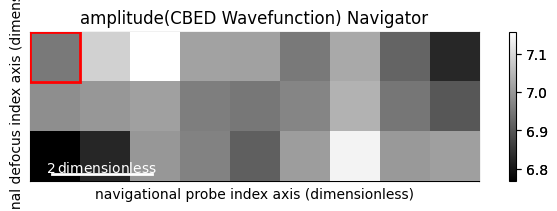

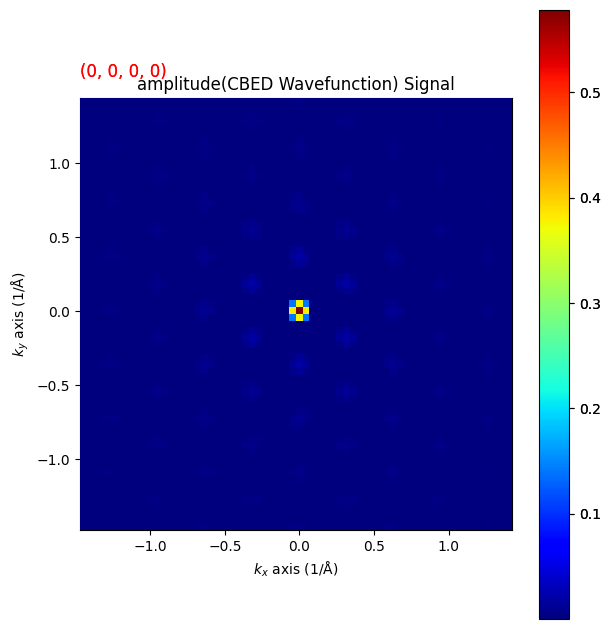

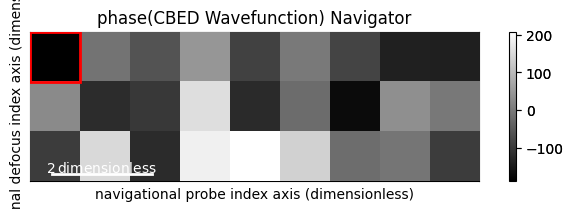

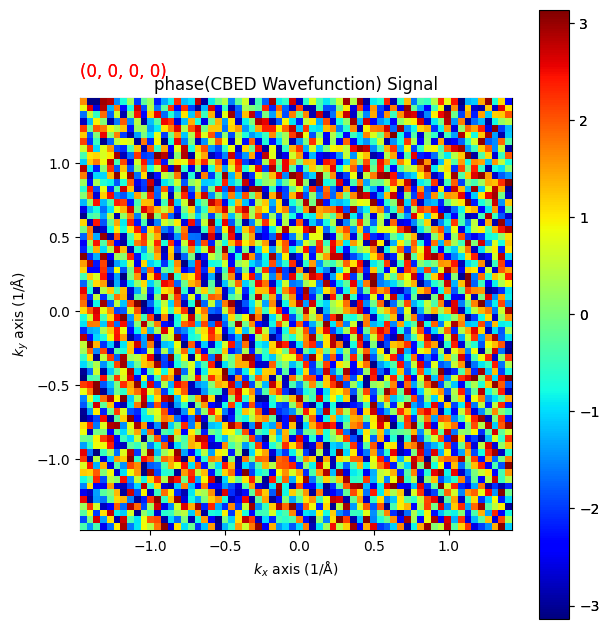

In [30]:
%matplotlib ipympl

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "gamma": 0.3, 
          "cmap": plt.get_cmap("jet")}
cbed_wavefunction_signal.plot(representation="polar", **kwargs)

## Loading CBED intensity patterns ##

Load a CBED intensity pattern subcollection into a ``hyperspy`` signal.

In [31]:
kwargs = {"filename": path_to_stem_sim_intensity_output, 
          "multi_dim_slice": (slice(None), slice(None)), 
          "use_two_axes_to_map_probe_position_if_possible": False}

cbed_intensity_pattern_signal, navigational_to_original_indices_map = \
    prismatique.load.cbed_intensity_patterns(**kwargs)

Show the "navigational to original indices" map.

In [32]:
navigational_to_original_indices_map

{'output_layer_indices': (0, 1, 2, 3),
 'probe_indices': (0, 1, 2, 3, 4, 5, 6, 7, 8)}

Show the CBED intensity pattern signal metadata.

In [33]:
cbed_intensity_pattern_signal.metadata

├── General
│   └── title = CBED Intensity Pattern
├── Prismatique
└── Signal
    ├── pixel value units = dimensionless
    └── signal_type =

Plot the CBED intensity pattern subcollection.

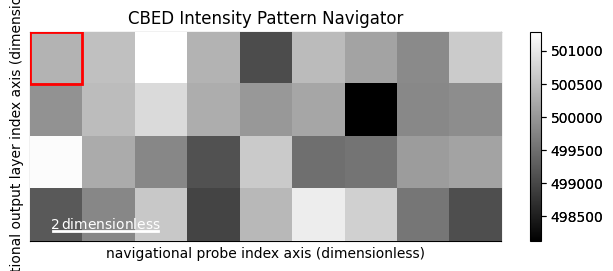

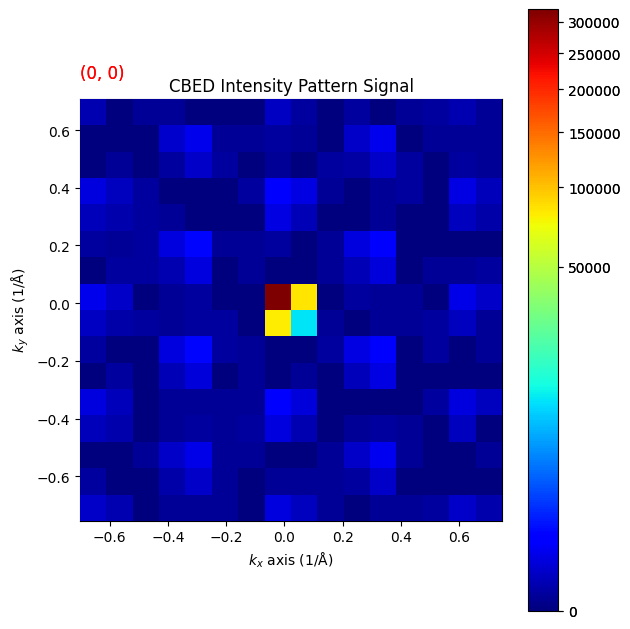

In [34]:
plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "gamma": 0.3,
          "cmap": plt.get_cmap("jet")}
cbed_intensity_pattern_signal.plot(**kwargs)

## Loading center-of-mass momentum patterns ##

Load a center-of-mass (COM) momentum pattern subcollection into a ``hyperspy``
signal.

In [35]:
kwargs = {"filename": path_to_stem_sim_intensity_output, 
          "multi_dim_slice": (slice(None), slice(None)), 
          "use_two_axes_to_map_probe_position_if_possible": False}

com_momentum_signal, navigational_to_original_indices_map = \
    prismatique.load.com_momenta(**kwargs)

Show the "navigational to original indices" map.

In [36]:
navigational_to_original_indices_map

{'output_layer_indices': (0, 1, 2, 3), 'vector_component_indices': (0, 1)}

Show the COM momentum pattern signal metadata.

In [37]:
com_momentum_signal.metadata

├── General
│   └── title = Center of Mass Momentum
├── Prismatique
└── Signal
    ├── pixel value units = 1/Å
    └── signal_type =

Plot the COM momentum pattern subcollection.

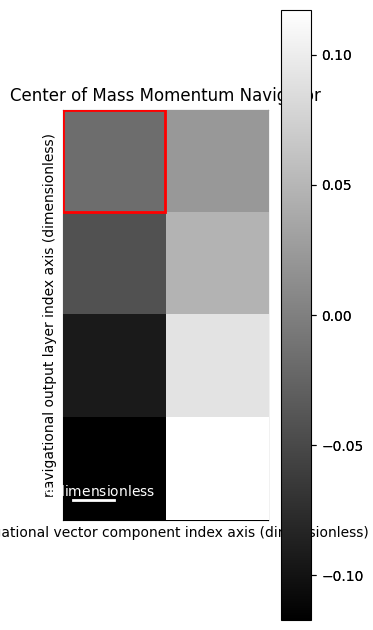

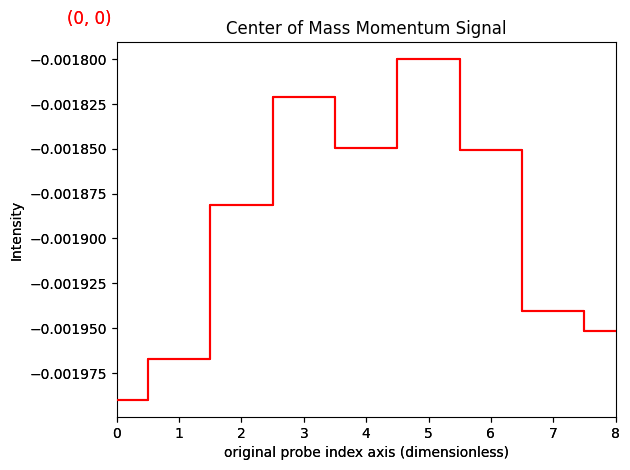

In [38]:
plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "vmin": None,
          "vmax": None,
          "cmap": plt.get_cmap("jet")}
com_momentum_signal.plot(**kwargs)

## Loading STEM intensity images ##

Load a STEM intensity image subcollection into a ``hyperspy`` signal.

In [39]:
kwargs = {"filename": path_to_stem_sim_intensity_output, 
          "multi_dim_slice": (slice(None),), 
          "use_two_axes_to_map_probe_position_if_possible": False}

stem_image_signal, navigational_to_original_indices_map = \
    prismatique.load.stem_intensity_images(**kwargs)

Show the "navigational to original indices" map.

In [40]:
navigational_to_original_indices_map

{'output_layer_indices': (0, 1, 2, 3)}

Show the STEM intensity image signal metadata.

In [41]:
stem_image_signal.metadata

├── General
│   └── title = STEM Intensity Image
├── Prismatique
│   └── integration limits = (0.0, 4.5)
└── Signal
    ├── pixel value units = dimensionless
    └── signal_type =

Plot the STEM intensity image subcollection.

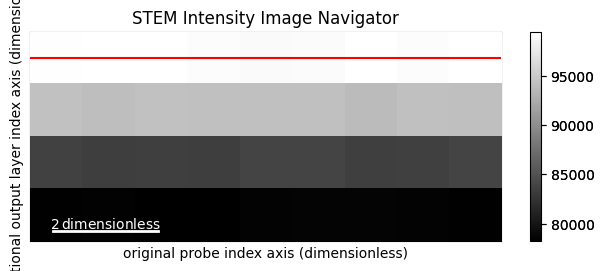

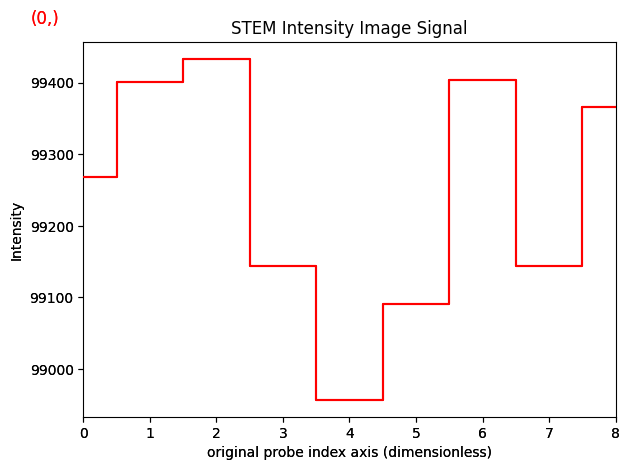

In [42]:
plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "vmin": None,
          "vmax": None,
          "cmap": plt.get_cmap("jet")}
stem_image_signal.plot(**kwargs)

## Loading 3D-STEM integrated intensity patterns ##

Load a 3D-STEM integrated intensity pattern subcollection into a ``hyperspy``
signal.

In [43]:
kwargs = {"filename": path_to_stem_sim_intensity_output, 
          "multi_dim_slice": (slice(None), slice(None)), 
          "use_two_axes_to_map_probe_position_if_possible": False}

intensity_3d_stem_signal, navigational_to_original_indices_map = \
    prismatique.load.azimuthally_integrated_cbed_intensity_patterns(**kwargs)

Show the "navigational to original indices" map.

In [44]:
navigational_to_original_indices_map

{'output_layer_indices': (0, 1, 2, 3),
 'probe_indices': (0, 1, 2, 3, 4, 5, 6, 7, 8)}

Show the 3D-STEM integrated intensity pattern signal metadata.

In [45]:
intensity_3d_stem_signal.metadata

├── General
│   └── title = Azimuthally Integrated CBED Intensity Pattern
├── Prismatique
└── Signal
    ├── pixel value units = dimensionless
    └── signal_type =

Plot the 3D-STEM intensity pattern subcollection.

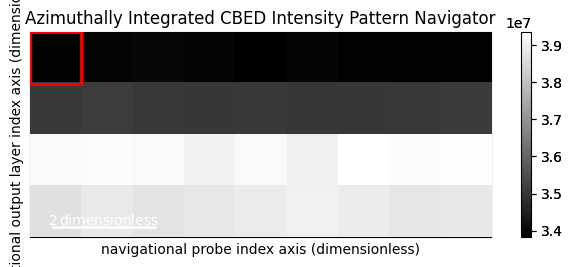

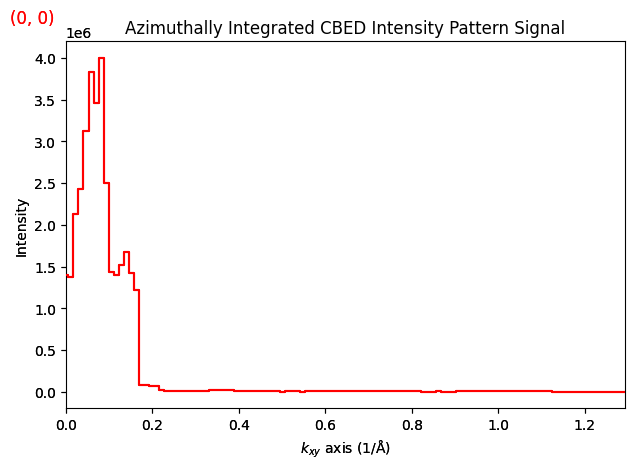

In [46]:
plt.close("all")  # Close all previous figures to release memory.

kwargs = {"colorbar": True,
          "scalebar": True,
          "axes_ticks": True,
          "vmin": None,
          "vmax": None,
          "cmap": plt.get_cmap("jet")}
intensity_3d_stem_signal.plot(**kwargs)